[Link to this document's Jupyter Notebook](./0316--Parallel_Python_pre-class-assignment.ipynb)

In order to successfully complete this assignment you must do the required reading, watch the provided videos and complete all instructions.  The embedded survey form must be entirely filled out and submitted on or before **11:59pm on Tuesday March 16**.  Students must come to class the next day prepared to discuss the material covered in this assignment. 

---



# Pre-Class Assignment: Parallel Python

### Goals for today's pre-class assignment 

1. [Matrix Multiply Example](#Matrix-Multiply-Example)
2. [Parallel Python example](#Parallel-Python-example)
3. [The Python GIL (Global Interface Lock)](#The-Python-GIL-(Global-Interface-Lock))
4. [Getting around the GIL](#Getting-around-the-GIL)
5. [Assignment wrap up](#Assignment-wrap-up)




---
<a name=Matrix-Multiply-Example></a>
# 1. Matrix Multiply Example



 The following is a simple implementation of a matrix multiply written in python. Review the code try to understand what it is doing.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import sympy as sp
import random
import time
sp.init_printing(use_unicode=True)

In [2]:
#simple matrix multiply (no numpy)
def multiply(m1,m2):
    m = len(m1)
    d = len(m2)
    n = len(m2[0])
    if len(m1[0]) != d:
        print("ERROR - inner dimentions not equal")
    result = [[0 for i in range(m)] for j in range(n)]
    for i in range(0,m):
        for j in range(0,n):
            for k in range(0,d):
                result[i][j] = result[i][j] + m1[i][k] * m2[k][j]
    return result

In [3]:
# Random generated 2d lists of lists that can be multiplied 
m = 4
d = 10
n = 4

A = [[random.random() for i in range(d)] for j in range(m)]
B = [[random.random() for i in range(n)] for j in range(d)]

In [4]:
#Compute matrix multiply using your function
start = time.time()

simple_answer = multiply(A, B)
simple_time = time.time()-start

print('simple_answer =',simple_time,'seconds')

simple_answer = 8.654594421386719e-05 seconds


Lets compare this to the numpy result:

In [5]:
#Compare to numpy result
start = time.time()

np_answer = np.matrix(A)*np.matrix(B)
np_time = time.time()-start

print('np_answer =',np_time,'seconds')


np_answer = 0.0719914436340332 seconds


For this example, numpy result are most likely slower than the simple result.  Think about why this might be.  We will discuss this later. 

&#9989; **<font color=red>DO THIS:</font>**  See if you can write a loop to do a scaling study for the above code.  Loop over the value of $n$ such that $n$ is 4, 16, 32, 64, 128 and 256.  For each iteration generate two random matrices (as above) with $m = d = n$. Then time the matrix multiply for the provided function and again for the numpy function. Graph the results as size of $n$ vs time.  

In [6]:
# Put your code here

&#9989; **<font color=red>DO THIS:</font>**  Explore the Internet for ways to speed up Python (There are a lot of them).  Save some of your search results in the cell below and come to class prepaired to discuss what you found.

Put your search results here.



---
<a name=Parallel-Python-example></a>
# 2. Parallel Python example



Here is an example for running parallel python using the ```multiprocessing``` library. 

https://stackoverflow.com/questions/10415028/how-can-i-recover-the-return-value-of-a-function-passed-to-multiprocessing-proce


In [7]:
import multiprocessing
num_procs = multiprocessing.cpu_count()
print('You have', num_procs, 'processors')

def worker(procnum, return_dict):
    '''worker function'''
    print(str(procnum) + ' represent!')
    return_dict[procnum] = procnum


if __name__ == '__main__':
    manager = multiprocessing.Manager()
    return_dict = manager.dict()
    jobs = []
    for i in range(5):
        p = multiprocessing.Process(target=worker, args=(i,return_dict))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()
    print(return_dict.values())

You have 256 processors
0 represent!
1 represent!
2 represent!
3 represent!
4 represent!
[0, 1, 2, 3, 4]


### Lets try to make a parallel matrix multiply

The following is the instructor's attempt at using multiprocessing to do matrix multiply. First lets start with a serial method.

In [8]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import sympy as sp
import random
import time
sp.init_printing(use_unicode=True)

In [9]:
#simple matrix multiply (no numpy)
def multiply(m1,m2):
    m = len(m1)
    d = len(m2)
    n = len(m2[0])
    if len(m1[0]) != d:
        print("ERROR - inner dimentions not equal")
    result = [[0 for i in range(m)] for j in range(n)]
    for i in range(0,m):
        for j in range(0,n):
            for k in range(0,d):
                result[i][j] = result[i][j] + m1[i][k] * m2[k][j]
    return result

In [26]:
# Random generated 2d lists of lists that can be multiplied 
m = 4
d = 10
n = 4

A = [[random.random() for i in range(d)] for j in range(m)]
B = [[random.random() for i in range(n)] for j in range(d)]

In [27]:
#Compute matrix multiply using your function


start = time.time()

simple_answer = multiply(A, B)
simple_time = time.time()-start

print('simple_answer =',simple_time,'seconds')

simple_answer = 9.34600830078125e-05 seconds


Lets compare this to the numpy result:

In [28]:
#Compare to numpy result
start = time.time()

np_answer = np.matrix(A)*np.matrix(B)
np_time = time.time()-start

print('np_answer =',np_time,'seconds')


np_answer = 0.00017523765563964844 seconds


In [29]:
#Compare to numpy result
A_ = np.matrix(A)
B_ = np.matrix(B)

start = time.time()

np_answer = A_*B_
np_time = time.time()-start

print('np_answer =',np_time,'seconds')

np_answer = 0.00017690658569335938 seconds


In [30]:
np.allclose(simple_answer,np_answer)

True

On some systems the numpy result may be slower than the simple result.  Think about why this might be.  We will discuss this later. 

### Now lets use multiprocessing to try and do a parallel method

In [20]:
#Attempt at a parallel multiply
def parallel_multiply(m1,m2):
    m = len(m1)
    d = len(m2)
    n = len(m2[0])

    def dot_worker(row,col):
        """thread worker function"""
        #print('Worker:', i,j)
        temp = 0
        for k in range(len(m2)):
            temp = temp + m1[row][k] * m2[k][col]
        return_dict[(row,col)] = temp
        return 

    jobs = []
    manager = multiprocessing.Manager()
    return_dict = manager.dict()

    for i in range(m):
        for j in range(n):
            #p = dot_worker(i,j)
            p = multiprocessing.Process(target=dot_worker, args=(i,j,))
            jobs.append(p)
            p.start()

    for proc in jobs:
        proc.join()
    
    print('Used',len(jobs),'threads in calculation.')
    
    C = return_dict.values()
    C = np.matrix(return_dict.values())
    C = C.reshape((m,n))
    return C

In [21]:
#Compute matrix multiply using your function
start = time.time()

parallel_answer = parallel_multiply(A, B)
parallel_time = time.time()-start

print('parallel_answer=',parallel_time,'seconds')

Used 16 threads in calculation.
parallel_answer= 0.09114575386047363 seconds


In [22]:
np.allclose(parallel_answer,np_answer)

True

Text(0.5, 1.0, 'Programming language usage')

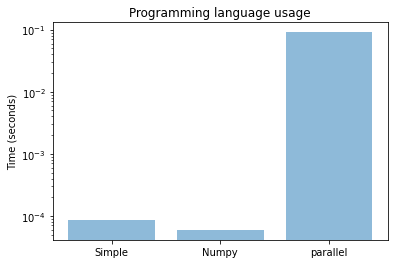

In [23]:
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('Simple', 'Numpy', 'parallel')
y_pos = np.arange(len(objects))
performance = [simple_time,np_time,parallel_time]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Time (seconds)')
plt.yscale('log')
plt.title('Programming language usage')
 

&#9989; **<font color=red>QUESTION:</font>** Why do you think the parallel version was so much slower than Python?

Put your answer to the above question here.



---
<a name=The-Python-GIL-(Global-Interface-Lock)></a>
# 3. The Python GIL (Global Interface Lock)



&#9989; **<font color=red>DO THIS:</font>** Read the following blog post and answer the questions: https://wiki.python.org/moin/GlobalInterpreterLock

&#9989; **<font color=red>QUESTION:</font>**  Why was the GIL introduced to the Python programming language?

Put your answer to the above question here.

&#9989; **<font color=red>QUESTION:</font>**  How does the GIL help avoid race conditions?

Put your answer to the above question here.

&#9989; **<font color=red>QUESTION:</font>**  How does the GIL help avoid deadlock?

Put your answer to the above question here.

&#9989; **<font color=red>QUESTION:</font>**  Why is the GIL problematic to parallel libraries like the "thread" and "multiprocessing" libraries?

Put your answer to the above question here.



---
<a name=Getting-around-the-GIL></a>
# 4. Getting around the GIL


Fortunately there are ways to get around the GIL. In fact, Python has libraries that do shared memory parallelization, shared network parallelization and GPU acceleration.  Do some research and answer the following questions:


&#9989; **<font color=red>QUESTION:</font>**  Some of ```numpy``` library can run in parallel. How does ```numpy``` get around the GIL? 

Put your answer to the above question here.

&#9989; **<font color=red>QUESTION:</font>**  The  ```numba``` library can also run in parallel. How does ```numba``` get around the GIL? 

Put your answer to the above question here.

&#9989; **<font color=red>QUESTION:</font>** What python library can be used to program GPUs?

Put your answer to the above question here.

&#9989; **<font color=red>QUESTION:</font>** What python library can be used to run shared network parallelization such as the Message Passing Interface (MPI)?

Put your answer to the above question here.

&#9989; **<font color=red>QUESTION:</font>** There seem to be a lot of solutions for running Python in parallel.  Provide an argument(s) as to why you would bother with an "older" language such as C/C++ or Fortran? 

Put your answer to the above question here.

----

<a name="Assignment_wrap-up"></a>
# 5. Assignment wrap-up

Please fill out the form that appears when you run the code below.  **You must completely fill this out in order to receive credits for the assignment!**

[Direct Link to Google Form](https://cmse.msu.edu/cmse401-pc-survey)


If you have trouble with the embedded form, please make sure you log on with your MSU google account at [googleapps.msu.edu](https://googleapps.msu.edu) and then click on the direct link above.

Put your answer to the above question here

&#9989; **<font color=red>QUESTION:</font>**  Summarize what you did in this assignment.

Put your answer to the above question here

&#9989; **<font color=red>QUESTION:</font>**  What questions do you have, if any, about any of the topics discussed in this assignment after working through the jupyter notebook?

Put your answer to the above question here

&#9989; **<font color=red>QUESTION:</font>**  How well do you feel this assignment helped you to achieve a better understanding of the above mentioned topic(s)?

Put your answer to the above question here

&#9989; **<font color=red>QUESTION:</font>** What was the **most** challenging part of this assignment for you? 

Put your answer to the above question here

&#9989; **<font color=red>QUESTION:</font>** What was the **least** challenging part of this assignment for you? 

Put your answer to the above question here

&#9989; **<font color=red>QUESTION:</font>**  What kind of additional questions or support, if any, do you feel you need to have a better understanding of the content in this assignment?

Put your answer to the above question here

&#9989; **<font color=red>QUESTION:</font>**  Do you have any further questions or comments about this material, or anything else that's going on in class?

Put your answer to the above question here

&#9989; **<font color=red>QUESTION:</font>** Approximately how long did this pre-class assignment take?

Put your answer to the above question here

In [19]:
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://cmse.msu.edu/cmse401-pc-survey" 
	width="100%" 
	height="500px" 
	frameborder="0" 
	marginheight="0" 
	marginwidth="0">
	Loading...
</iframe>
"""
)



---------
### Congratulations, we're done!

To get credit for this assignment you must fill out and submit the above survey from on or before the assignment due date.

### Course Resources:


 - [Website](https://msu-cmse-courses.github.io/cmse802-f20-student/)
 - [ZOOM](https://msu.zoom.us/j/98207034052)
 - [JargonJar](https://docs.google.com/document/d/1ahg48CCFhRzUL-QIHzlt_KEf1XqsCasFBU4iePHhcug/edit#)
 - [GIT](https://gitlab.msu.edu/colbrydi/cmse401-s21.git)



Written by Dr. Dirk Colbry, Michigan State University
<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

----

----